# Import

In [2]:
import torch
import torch.nn as nn
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load Data

In [15]:
california = fetch_california_housing()
data = california.data
targets = california.target  

scaler = StandardScaler()
data = scaler.fit_transform(data)

X_train, X_test, Y_train, Y_test = train_test_split(data, targets, test_size=0.2, random_state=42)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
X_validation = torch.FloatTensor(X_validation)
Y_train = torch.FloatTensor(Y_train).view(-1, 1)
Y_validation = torch.FloatTensor(Y_validation).view(-1, 1)
Y_test = torch.FloatTensor(Y_test).view(-1, 1)

# Model Class

In [16]:
class Regression(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, hidden3):
        super(Regression, self).__init__()
        self.W1 = nn.Parameter(torch.randn(input_dim, hidden1) * 0.01)
        self.b1 = nn.Parameter(torch.zeros(hidden1))
        self.W2 = nn.Parameter(torch.randn(hidden1, hidden2) * 0.01)
        self.b2 = nn.Parameter(torch.zeros(hidden2))
        self.W3 = nn.Parameter(torch.randn(hidden2, hidden3) * 0.01)
        self.b3 = nn.Parameter(torch.zeros(hidden3))
        self.W_out = nn.Parameter(torch.randn(hidden3, 1) * 0.01)
        self.b_out = nn.Parameter(torch.zeros(1))
        self.relu = nn.ReLU()

    def forward(self, X):
        x = self.relu(torch.mm(X, self.W1) + self.b1)
        x = self.relu(torch.mm(x, self.W2) + self.b2)
        x = self.relu(torch.mm(x, self.W3) + self.b3)
        x = torch.mm(x, self.W_out) + self.b_out
        return x

# Training Model

In [ ]:
input_dim = X_train.shape[1]
hidden1 = 64
hidden2 = 32
hidden3 = 16
model = Regression(input_dim, hidden1, hidden2, hidden3)

criterion = nn.MSELoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

batch_size = 20
train_data = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data = TensorDataset(X_validation, Y_validation)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
train_losses = []
val_losses = []
def train_model(epochs):
    for epoch in range(epochs):
        model.train()
        batch_loss = 0
        for x_batch, y_batch in train_loader:
            yhat = model(x_batch)
            loss = criterion(yhat, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_loss += loss.item()
        train_loss = batch_loss / len(train_loader)
        train_losses.append(train_loss)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                yhat = model(x_batch)
                loss = criterion(yhat, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        print(f" {epoch}   Validation Loss: {val_loss:.4f}")

epochs = 50
train_model(epochs)



In [24]:
model.eval()
with torch.no_grad():
    predictions=model(X_test)
    Y_test = Y_test.float()
    predictions = predictions.float()
    mse = torch.mean((predictions - Y_test) ** 2)
    mae = torch.mean(torch.abs(predictions - Y_test))
    tss = torch.sum((Y_test - torch.mean(Y_test)) ** 2)
    rss = torch.sum((Y_test - predictions) ** 2)
    r2 = 1 - (rss / tss)

    print(f'Mean Squared Error: {mse.item()}')
    print(f'Mean Absolute Error: {mae.item()}')
    print(f'R^2 Score: {r2.item()}')

Mean Squared Error: 0.2872895896434784
Mean Absolute Error: 0.3611656725406647
R^2 Score: 0.7807634472846985


# Plot Data


Evaluation Metrics:
Mean Squared Error (MSE): 0.2873
Mean Absolute Error (MAE): 0.3612
R² Score: 0.7808


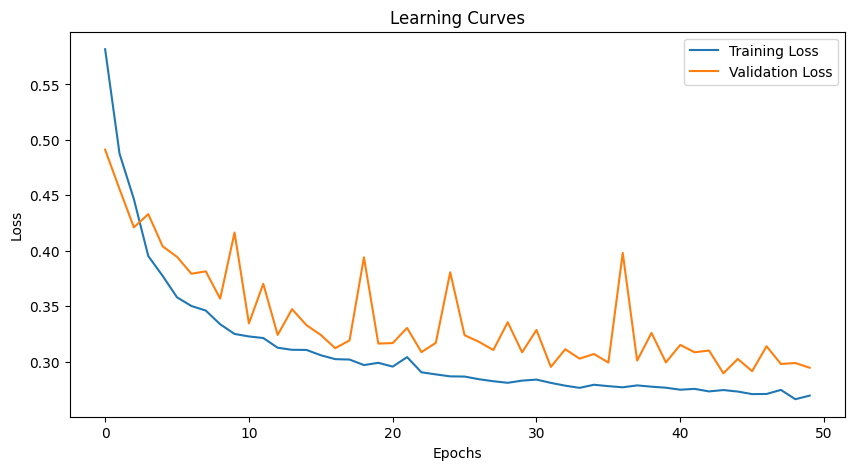

In [25]:
print("\nEvaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_losses, label="Training Loss")
plt.plot(range(epochs), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curves")
plt.legend()
plt.show()